<a href="https://colab.research.google.com/github/joekakone/learn_data_science/blob/master/Cr%C3%A9er_Notre_Propre_G%C3%A9n%C3%A9rateur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Créer son propre génératuer : Une aternative à ImageDataGenerator

Les images sont généralement chargées avec ImageDataGenerator avec une contrainte d'avoir les images représentant les mêmes classes dans les dossiers.

Avantage: On n'est plus obligé d'avoir les images dans différents dossiers.

Désavantage: Nous n'avaons plus l'option «Augmenter les images»

In [ ]:
# connection to drive
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

BASE_ROOT = './tensorflow-hub'
if not os.path.exists(BASE_ROOT):
    os.makedirs(BASE_ROOT)
os.chdir(BASE_ROOT)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import os
import math

import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
DATA_ROOT = './flower_photos/'

In [ ]:
# classes's names as floders's names
classes = [it for it in os.listdir(DATA_ROOT) if it != 'LICENSE.txt']
classes = sorted(classes) # sort list
num_classes = len(classes)
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# mapping classes to label (int)
classes = {classes[i]: i for i in range(len(classes))}
classes

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
# listing all images paths
all_images = glob.glob(DATA_ROOT+'*/*.jpg')
np.random.shuffle(all_images)
n_samples = len(all_images)
n_samples

3670

In [ ]:
# associate label to each image
labels = [path.split('/')[-2] for path in all_images]
len(labels)

3670

In [ ]:
# converting labels
labels = [classes[label] for label in labels]
labels[0]

0

# Générateur Personnalisé
La personnalisation du générateur se fait sur l'association des chemins des images et des classes associées.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten

In [ ]:
IMG_SIZE = 150
NUM_CHANNELS = 3
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
BATCH_SIZE = 80

In [ ]:
def load_image(path):
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize(TARGET_SIZE)
    image = np.array(image) / 255.0
    image = image.reshape(INPUT_SHAPE)
    return image

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size=32, target_size=(150, 150)):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            load_image(file_name)
               for file_name in batch_x]), np.array(batch_y)

In [ ]:
train_samples = int(n_samples*.8)

In [ ]:
train_generator = DataGenerator(all_images[:train_samples], labels[:train_samples], BATCH_SIZE, TARGET_SIZE)
val_generator = DataGenerator(all_images[train_samples:], labels[train_samples:], BATCH_SIZE, TARGET_SIZE)

In [ ]:
base_model = InceptionV3(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
EPOCHS = 30

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS)

Epoch 1/30
37/37 [==============================] - 155s 4s/step - loss: 4.7495 - acc: 0.5453 - val_loss: 1.2976 - val_acc: 0.5995
Epoch 2/30
37/37 [==============================] - 153s 4s/step - loss: 0.9142 - acc: 0.7193 - val_loss: 0.6433 - val_acc: 0.7984
Epoch 3/30
37/37 [==============================] - 155s 4s/step - loss: 0.8448 - acc: 0.7493 - val_loss: 0.5365 - val_acc: 0.8229
Epoch 4/30
37/37 [==============================] - 152s 4s/step - loss: 0.7257 - acc: 0.7854 - val_loss: 0.7280 - val_acc: 0.7820
Epoch 5/30
37/37 [==============================] - 152s 4s/step - loss: 0.5244 - acc: 0.8249 - val_loss: 0.9902 - val_acc: 0.7207
Epoch 6/30
37/37 [==============================] - 152s 4s/step - loss: 0.4720 - acc: 0.8563 - val_loss: 0.7242 - val_acc: 0.7916
Epoch 7/30
37/37 [==============================] - 156s 4s/step - loss: 0.3913 - acc: 0.8743 - val_loss: 0.4956 - val_acc: 0.8379
Epoch 8/30
37/37 [==============================] - 153s 4s/step - loss: 0.3233 - a

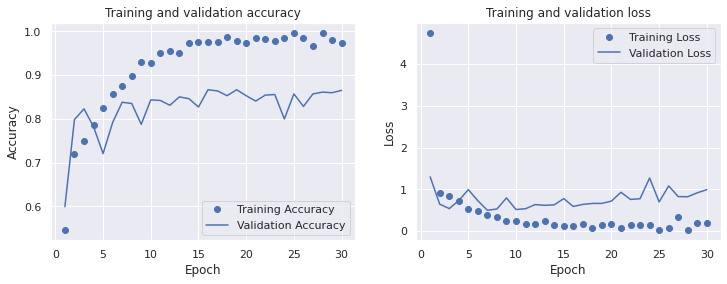

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

plt.show()

In [ ]:
res =  model.evaluate(val_generator)
print(f'Validation Loss: {res[0]}')
print(f'Validation Accuracy: {res[1]}')

10/10 [==============================] - 27s 3s/step - loss: 0.9910 - acc: 0.8651
Validation Loss: 0.9909815192222595
Validation Accuracy: 0.8651226162910461
